# Deploying yolort on TensorRT

Unlike other pipelines that deal with yolov5 on TensorRT, we embed the whole post-processing into the Graph with `onnx-graghsurgeon`. We gain a lot with this whole pipeline. The ablation experiment results are below. The first one is the result without running `EfficientNMS_TRT`, and the second one is the result with `EfficientNMS_TRT` embedded. As you can see, the inference time is even reduced, we guess it is because the data copied to the device will be much less after doing `EfficientNMS_TRT`. (The mean Latency of D2H is reduced from `0.868048 ms` to `0.0102295 ms`, running on Nivdia Geforce GTX 1080ti, using TensorRT 8.2 with yolov5n6 and scaling images to `512x640`.)

And `onnx-graphsurgeon` is easy to install, you can just use their prebuilt wheels:

```
python3 -m pip install onnx_graphsurgeon --index-url https://pypi.ngc.nvidia.com
```

The detailed results:

```
[I] === Performance summary w/o EfficientNMS_TRT plugin ===
[I] Throughput: 383.298 qps
[I] Latency: min = 3.66479 ms, max = 5.41199 ms, mean = 4.00543 ms, median = 3.99316 ms, percentile(99%) = 4.23831 ms
[I] End-to-End Host Latency: min = 3.76599 ms, max = 6.45874 ms, mean = 5.08597 ms, median = 5.07544 ms, percentile(99%) = 5.50839 ms
[I] Enqueue Time: min = 0.743408 ms, max = 5.27966 ms, mean = 0.940805 ms, median = 0.924805 ms, percentile(99%) = 1.37329 ms
[I] H2D Latency: min = 0.502045 ms, max = 0.62674 ms, mean = 0.538255 ms, median = 0.537354 ms, percentile(99%) = 0.582153 ms
[I] GPU Compute Time: min = 2.23233 ms, max = 3.92395 ms, mean = 2.59913 ms, median = 2.58661 ms, percentile(99%) = 2.8201 ms
[I] D2H Latency: min = 0.851807 ms, max = 0.900421 ms, mean = 0.868048 ms, median = 0.867676 ms, percentile(99%) = 0.889191 ms
[I] Total Host Walltime: 3.0081 s
[I] Total GPU Compute Time: 2.99679 s
[I] Explanations of the performance metrics are printed in the verbose logs.
[I]
&&&& PASSED TensorRT.trtexec [TensorRT v8201] # trtexec --onnx=yolov5n6-no-nms.onnx --workspace=8096
```

```
[I] === Performance summary w/ EfficientNMS_TRT plugin ===
[I] Throughput: 389.234 qps
[I] Latency: min = 2.81482 ms, max = 9.77234 ms, mean = 3.1062 ms, median = 3.07642 ms, percentile(99%) = 3.33548 ms
[I] End-to-End Host Latency: min = 2.82202 ms, max = 11.6749 ms, mean = 4.939 ms, median = 4.95587 ms, percentile(99%) = 5.45207 ms
[I] Enqueue Time: min = 0.999878 ms, max = 11.3833 ms, mean = 1.28942 ms, median = 1.18579 ms, percentile(99%) = 4.53088 ms
[I] H2D Latency: min = 0.488159 ms, max = 0.633881 ms, mean = 0.546754 ms, median = 0.546631 ms, percentile(99%) = 0.570557 ms
[I] GPU Compute Time: min = 2.30298 ms, max = 9.21094 ms, mean = 2.54921 ms, median = 2.51904 ms, percentile(99%) = 2.78528 ms
[I] D2H Latency: min = 0.00610352 ms, max = 0.302734 ms, mean = 0.0102295 ms, median = 0.00976562 ms, percentile(99%) = 0.0151367 ms
[I] Total Host Walltime: 3.00591 s
[I] Total GPU Compute Time: 2.98258 s
[I] Explanations of the performance metrics are printed in the verbose logs.
[I]
&&&& PASSED TensorRT.trtexec [TensorRT v8201] # trtexec --onnx=yolov5n6-efficient-nms.onnx --workspace=8096
```

## TensorRT Installation Instructions

For us to unfold the subsequent story, TensorRT should be installed and the minimal version of TensorRT to run this demo is 8.2.0. Check out the TensorRT installation guides at <https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html>. You can use the Python wheels provided by TensorRT if you only want to use the Python interface:

```
pip install -U nvidia-tensorrt --index-url https://pypi.ngc.nvidia.com
```

These wheels only works on Ubuntu 18.04+ or CentOS 7+ with Python versions 3.6 to 3.9 and CUDA 11.x. Check out the details at <https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html#installing-pip>.

There are many ways to install the whole TensorRT at <https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html#installing>. One option to use the C++ interface of TensorRT is via docker. We've tested the docker published by Meta (Facebook) containing the TensorRT and PyTorch at NVIDIA GPU Cloud (NGC): <https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch>.

In [1]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
cuda_visible = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_visible

assert torch.cuda.is_available()
device = torch.device('cuda')

import tensorrt as trt
print(f"We're using TensorRT: {trt.__version__} on {device} device: {cuda_visible}.")

We're using TensorRT: 8.2.4.2 on cuda device: 0.


In [2]:
import cv2

from yolort.utils import Visualizer
from yolort.v5 import attempt_download
from yolort.v5.utils.downloads import safe_download

## Prepare image and model weights to test

In [3]:
# Define some parameters
batch_size = 1
img_size = 640
size_divisible = 32
fixed_shape = True
score_thresh = 0.35
nms_thresh = 0.45
detections_per_img = 100
# Must upgrade TensorRT to 8.2.4 or higher to use fp16 mode.
precision = "fp16"

In [4]:
# img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/zidane.jpg"
img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/bus.jpg"
img_path = img_source.split("/")[-1]
safe_download(img_path, img_source)
img_raw = cv2.imread(img_path)

  0%|          | 0.00/476k [00:00<?, ?B/s]

In [5]:
# yolov5s6.pt is downloaded from 'https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5n6.pt'
model_path = "yolov5s.pt"

checkpoint_path = attempt_download(model_path)
onnx_path = "yolov5s.onnx"
engine_path = "yolov5s.engine"

## Export to ONNX and TensorRT model

We provide a utilization tool `export_tensorrt_engine` for exporting TensorRT engines.

In [6]:
from yolort.runtime.trt_helper import export_tensorrt_engine

In [7]:
input_sample = torch.rand(batch_size, 3, img_size, img_size)

In [8]:
export_tensorrt_engine(
    model_path,
    score_thresh=score_thresh,
    nms_thresh=nms_thresh,
    onnx_path=onnx_path,
    engine_path=engine_path,
    input_sample=input_sample,
    detections_per_img=detections_per_img,
    precision=precision
)

Loaded saved model from yolov5s.pt
/root/miniconda3/envs/torch/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/workspace/yolo/yolov5-rt-stack/yolort/models/anchor_utils.py:46: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  anchors = torch.as_tensor(self.anchor_grids, dtype=torch.float32, device=device).to(dtype=dtype)
/workspace/yolo/yolov5-rt-stack/yolort/models/anchor_utils.py:47: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ign

[W] 'Shape tensor cast elision' routine failed with: None


Created NMS plugin 'EfficientNMS_TRT' with attributes: {'plugin_version': '1', 'background_class': -1, 'max_output_boxes': 100, 'score_threshold': 0.35, 'iou_threshold': 0.45, 'score_activation': False, 'box_coding': 0}
Saved ONNX model to yolov5s.onnx
Network Description
Input 'images' with shape (1, 3, 640, 640) and dtype DataType.FLOAT
Output 'num_detections' with shape (1, 1) and dtype DataType.INT32
Output 'detection_boxes' with shape (1, 100, 4) and dtype DataType.FLOAT
Output 'detection_scores' with shape (1, 100) and dtype DataType.FLOAT
Output 'detection_classes' with shape (1, 100) and dtype DataType.INT32
Building fp16 Engine in yolov5s.engine


[05/22/2022-10:07:35] [TRT] [I] [MemUsageChange] Init CUDA: CPU +457, GPU +0, now: CPU 674, GPU 354 (MiB)
[05/22/2022-10:07:35] [TRT] [I] [MemUsageSnapshot] Begin constructing builder kernel library: CPU 674 MiB, GPU 354 MiB
[05/22/2022-10:07:35] [TRT] [I] [MemUsageSnapshot] End constructing builder kernel library: CPU 828 MiB, GPU 398 MiB
[05/22/2022-10:07:35] [TRT] [I] ----------------------------------------------------------------
[05/22/2022-10:07:35] [TRT] [I] Input filename:   yolov5s.onnx
[05/22/2022-10:07:35] [TRT] [I] ONNX IR version:  0.0.8
[05/22/2022-10:07:35] [TRT] [I] Opset version:    11
[05/22/2022-10:07:35] [TRT] [I] Producer name:    
[05/22/2022-10:07:35] [TRT] [I] Producer version: 
[05/22/2022-10:07:35] [TRT] [I] Domain:           
[05/22/2022-10:07:35] [TRT] [I] Model version:    0
[05/22/2022-10:07:35] [TRT] [I] Doc string:       
[05/22/2022-10:07:35] [TRT] [I] ----------------------------------------------------------------
[05/22/2022-10:07:35] [TRT] [W] pars

Serialize engine success, saved as yolov5s.engine


[05/22/2022-10:11:30] [TRT] [I] Detected 1 inputs and 4 output network tensors.
[05/22/2022-10:11:30] [TRT] [I] Total Host Persistent Memory: 133584
[05/22/2022-10:11:30] [TRT] [I] Total Device Persistent Memory: 15045120
[05/22/2022-10:11:30] [TRT] [I] Total Scratch Memory: 40320768
[05/22/2022-10:11:30] [TRT] [I] [MemUsageStats] Peak memory usage of TRT CPU/GPU memory allocators: CPU 17 MiB, GPU 4371 MiB
[05/22/2022-10:11:30] [TRT] [I] [BlockAssignment] Algorithm ShiftNTopDown took 6.00966ms to assign 7 blocks to 88 nodes requiring 52609025 bytes.
[05/22/2022-10:11:30] [TRT] [I] Total Activation Memory: 52609025
[05/22/2022-10:11:30] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 4880, GPU 2272 (MiB)
[05/22/2022-10:11:30] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 4880, GPU 2280 (MiB)
[05/22/2022-10:11:30] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in building engine: CPU +14, GPU +15, now: CPU 14, GPU 15 (MiB)


## Test the exported TensorRT engine

Actually the above exported TensorRT engine only contains the post-processing (`nms`). And we wrap the pre-processing named `YOLOTransform` into a new module `PredictorTRT` for easy of use.

In [9]:
from yolort.runtime import PredictorTRT

In [10]:
y_runtime = PredictorTRT(engine_path, device=device)

Loading yolov5s.engine for TensorRT inference...


[05/22/2022-10:15:09] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.

[05/22/2022-10:15:09] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 4832, GPU 2224 (MiB)
[05/22/2022-10:15:09] [TRT] [I] Loaded engine size: 17 MiB
[05/22/2022-10:15:09] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +10, now: CPU 4856, GPU 2250 (MiB)
[05/22/2022-10:15:09] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 4856, GPU 2258 (MiB)
[05/22/2022-10:15:09] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +14, now: CPU 0, GPU 14 (MiB)
[05/22/2022-10:15:09] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +10, now: CPU 4839, GPU 2272 (MiB)
[05/22/2022-10:15:09] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 4839, GPU 

Let's warmup the engine by running inference once for GPU device.

In [11]:
y_runtime.warmup()

### Inferencing with TensorRT

In [12]:
%%timeit
predictions_trt = y_runtime.predict(img_path)

9.14 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
predictions_trt = y_runtime.predict(img_path)

In [14]:
predictions_trt

[{'scores': tensor([0.83447, 0.82812, 0.78613, 0.77930, 0.46411], device='cuda:0'),
  'labels': tensor([0, 0, 0, 5, 0], device='cuda:0', dtype=torch.int32),
  'boxes': tensor([[221.06250, 407.53125, 345.51562, 874.96875],
          [662.34375, 386.22656, 810.84375, 880.03125],
          [ 57.58594, 396.98438, 214.94531, 918.00000],
          [ 14.55469, 221.69531, 799.03125, 784.68750],
          [ -0.94922, 553.50000,  72.45703, 874.96875]], device='cuda:0')}]

## Predict as yolort

In [15]:
from yolort.models import YOLOv5

In [16]:
model = YOLOv5.load_from_yolov5(
    model_path,
    size=(img_size, img_size),
    size_divisible=size_divisible,
    fixed_shape=(img_size, img_size),
    score_thresh=score_thresh,
    nms_thresh=nms_thresh,
)

model = model.eval()
model = model.to(device)

### Inferencing with PyTorch

In [17]:
predictions_pt = model.predict(img_path)

## Verify the detection results between yolort and TensorRT

In [18]:
# Testing boxes
torch.testing.assert_close(predictions_pt[0]["boxes"], predictions_trt[0]["boxes"])
# Testing scores
torch.testing.assert_close(predictions_pt[0]["scores"], predictions_trt[0]["scores"])
# Testing labels
torch.testing.assert_close(predictions_pt[0]["labels"], predictions_trt[0]["labels"].to(dtype=torch.int64))

print("Exported model has been tested, and the result looks good!")

AssertionError: Tensor-likes are not close!

Mismatched elements: 20 / 20 (100.0%)
Greatest absolute difference: 0.689453125 at index (3, 2) (up to 1e-05 allowed)
Greatest relative difference: 0.054497612847222224 at index (4, 0) (up to 1.3e-06 allowed)


## Visualize the TensorRT detections

Get label names first.

In [19]:
# label_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/main/notebooks/assets/coco.names"
label_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/coco.names"
label_path = label_source.split("/")[-1]
safe_download(label_path, label_source)

  0%|          | 0.00/621 [00:00<?, ?B/s]

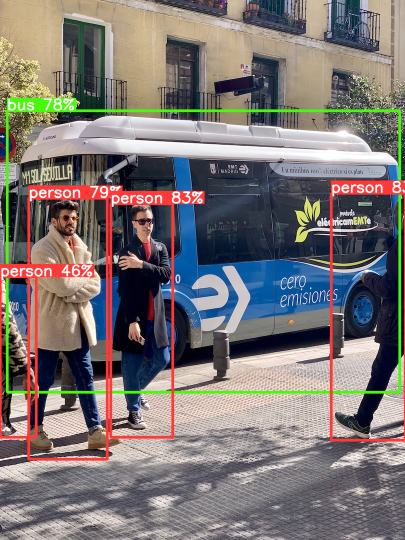

In [20]:
v = Visualizer(img_raw, metalabels=label_path)
v.draw_instance_predictions(predictions_trt[0])
v.imshow(scale=0.5)